##Image Classification and Object Localization

Build a CNN from scrath to:
* Classify the main subject in an image
* Localize it by drawing a bounding box around it

Use the MNIST dataset to synthesize custom datasets for the task 
* Place each 'digit' image on a black canvas of width 75x75 at random locations 
* Calculate the corresponding bounding boxes for those 'digits'

The bounding box prediction can be modelled as a 'regression' task which means that the model will predict a numeric value (as opposed to a category)

##Imports 

In [37]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import tensorflow_datasets as tfds 

In [38]:
##Visualization Utilities

im_width = 75
im_height = 75

use_normalized_coordinates = True

In [39]:
def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):


  """
  Draws bounding boxes on image (numpy array).

  Args:
    image: a numpy array object
    boxes: a 2-dim numpy array of [N, 4]: (ymin, xmin, ymax, xmax). The coordinates are normalized between 0 and 1 values
    color: color to draw bounding box. Default is red 
    thickness: line thickness. Default value is 4
    display_str_list_list: a list of strings for each bounding box

  Raises:
    ValueError: if boxes is not a [N, 4] array
  """

  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new('RGBA', image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)

  return np.array(rgbimg)


In [40]:
def draw_bounding_boxes_on_image(image, 
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """
  Draws bounding boxes on image

  Args:
    image: a PIL.Image object
    boxes: a 2D numpy array of [N, 4]: (ymin, xmin, ymax, xmax)
    color: color to draw bounding box
    thickness: line thickness
    display_str_list: a list of strings for each bounding box

  Raises:
    ValueError: if boxes are not in a [N, 4] array
  """

  boxes_shape = boxes.shape
  if not boxes_shape:
    return 
  if len(boxes_shape) != 2 or boxes_shape[1] != 4: 
    raise ValueError('Input must be of size [N, 4]')
  
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])

In [41]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  
  """
  Adds a bounding box to an image
  Bounding box coordinates can be specified in either absolute (pixel) or normalized coordinates by seeting the use_normalized_coordinates argument

  Args:
    image: a PIL.Image object
    ymin: ymin of bounding box
    xmin: xmin of bounding box
    ymax: ymax of bounding box
    xmax: xmax of bounding box
    color: color to draw bounding box
    thickness: line thickness
    display_str_list: string to display in box
    use_normalized_coordinates: if True (default), treat coordinates ymin, xmin, ymax, xmax, as relative to the image
  """

  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width,
                                  xmax * im_width,
                                  ymin * im_height, 
                                  ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)

  draw.line([ (left, top),
              (left, bottom),
              (right, bottom),
              (right, top),
              (left, top),],
            width=thickness,
            fill=color)

##Data and Prediction Visualization Utilities

In [42]:
"""
This cell contains helper functions used for visualization
and downloads only. 

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])
    
    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])
    
    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')

    
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

##Selecting Between Strategies

Depending on the hardware available, use either the TPU or the GPU strategies.

* If the TPU is available, use the TPU strategy
* Otherwise if more than one GPU is available, use the Mirrored Strategy 
* If one GPU is available or just the CPU is available, use the default strategy 

In [43]:
#Detect Harware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() #TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices('GPU')
  print('tpu not available')

In [44]:
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu) 
#Going back and forth between TPU and Host is expensive. Better to run 128 batches on the TPU before running back 
print("Running on TPU", tpu.cluster_spec().as_dict()['worker'])

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.18.147.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.18.147.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU ['10.18.147.130:8470']


##Parameters
The global batch size is the batch size per replica (64) times the number of replicas in the distribution strategy

In [45]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

The global batch size will automatically be sharded across all replicas by the tf.data.Dataset API

A single TPU has 8 cores 

The best practice is to scale the batch size by the number of replicas (cores) with the learning rate increasing as well

##Loading and Preprocessing the Dataset

Define some functions that will aid in pre-processing the data:
* `read_image_tfds`: randomly overlays the 'digit' image on top of a larger canvas
* `get_training_dataset`: loads data and splits it to get the training set 
* `get_validation_dataset`: loads and splits the data to get the validation set

In [46]:
def read_image_tfds(image, label):
  """
  Transform each image in the dataset by pasting it on a 75x75 canvas at a random location
  """
  x_min = tf.random.uniform((), 0, 48, dtype=tf.int32)
  y_min = tf.random.uniform((), 0, 48, dtype=tf.int32)

  image = tf.reshape(image, (28,28,1))
  image = tf.image.pad_to_bounding_box(image, y_min, x_min, 75, 75)
  
  image = tf.cast(image, tf.float32)
  x_min = tf.cast(x_min, tf.float32)
  y_min = tf.cast(y_min, tf.float32)

  x_max = (x_min + 28) / 75
  y_max = (y_min + 28) / 75
  x_min = x_min / 75
  y_min = y_min / 75

  return image, (tf.one_hot(label, 10), [x_min, y_min, x_max, y_max])

In [47]:
def get_training_dataset():
  """
  Loads and map the training split of the dataset using the map function
  Note that an attempt is made to load the gcs version since TPU can only work with datasets on Google Cloud Storage
  """
  with strategy.scope():
    dataset = tfds.load('mnist', split='train', as_supervised=True, try_gcs=True) #Google Cloud Storage
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() #mandatory for keras now
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) #drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1) #Fetch the next batches while training on the current one 
  return dataset

In [48]:
def get_validation_dataset():
  """
  Loads and maps the validation split of the dataset using the map function. Same as training verison 
  """

  with strategy.scope():
    dataset = tfds.load('mnist', split='test', as_supervised=True, try_gcs=True) #Google Cloud Storage
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(10000, drop_remainder=True) #drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.repeat()

  return dataset

In [49]:
with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

##Visualize the Data

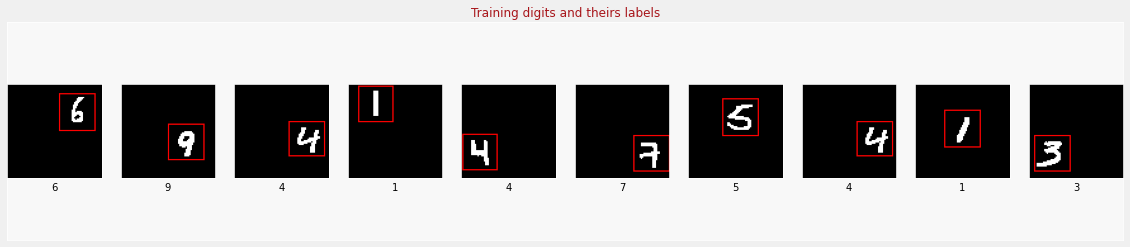

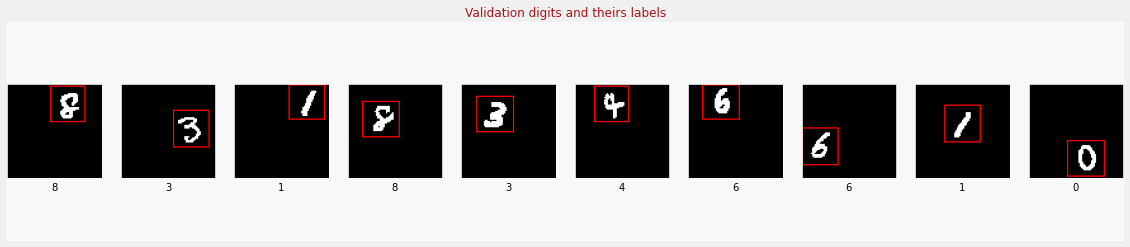

In [50]:
(training_digits, training_labels, training_bboxes, 
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, 
                                                                                  validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, 
                          np.array([]), training_bboxes,np.array([]), "Training digits and theirs labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, 
                          np.array([]), validation_bboxes,np.array([]), "Validation digits and theirs labels")

##Define the Model 

Define the custom CNN:
* feature_extractor: these convolutional layers extract the features of the image
* classifier: this defines the output layer that predicts among 10 categories (digits 0 through 9)
* bounding_box_regression: This defines the output layer that predicts 4 numeric values, which define the coordinates of the bounding box
* final_model: This combines the layers for feature extraction, classification and bounding box prediction 
* define_and_compile_model: Choose the optimizer and metrics and then compile the model 


In [51]:
def feature_extractor(inputs):
  x = tf.keras.layers.Conv2D(16, activation = 'relu', 
                             kernel_size = 3,
                             input_shape=(75, 75, 1))(inputs)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)

  return x


In [84]:
def dense_layers(inputs):
  """
  Adds Flatten() and (Dense) layer
  Follow feature_extractor layer
  """

  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)

  return x

In [77]:
def classifier(inputs):
  classification_output = tf.keras.layers.Dense(units=10, activation='softmax', name='classification')(inputs)

  return classification_output

In [66]:
def bounding_box_regression(inputs):
  bounding_box_regression_output = tf.keras.layers.Dense(units=4, name='bounding_box')(inputs)

  return bounding_box_regression_output

In [64]:
def final_model(inputs):
  feature_cnn = feature_extractor(inputs)
  dense_output = dense_layers(feature_cnn)

  #The model branches here: The Dense layer's output gets fed into two branches: classification_output and bounding_box_output

  classification_output = classifier(dense_output)
  bounding_box_output = bounding_box_regression(dense_output)

  model = tf.keras.Model(inputs=inputs, outputs=[classification_output, bounding_box_output])

  return model

In [71]:
def define_and_compile_model(inputs):
  model = final_model(inputs)

  model.compile(optimizer='adam',
                loss={'classification':'categorical_crossentropy',
                      'bounding_box':'mse'},
                metrics={'classification':'accuracy',
                         'bounding_box':'mse'})
  
  return model 

In [85]:
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75,75,1))
  model = define_and_compile_model(inputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 73, 73, 16)   160         ['input_7[0][0]']                
                                                                                                  
 average_pooling2d_13 (AverageP  (None, 36, 36, 16)  0           ['conv2d_18[0][0]']              
 ooling2D)                                                                                        
                                                                                                  
 conv2d_19 (Conv2D)             (None, 34, 34, 32)   4640        ['average_pooling2d_13[0][0

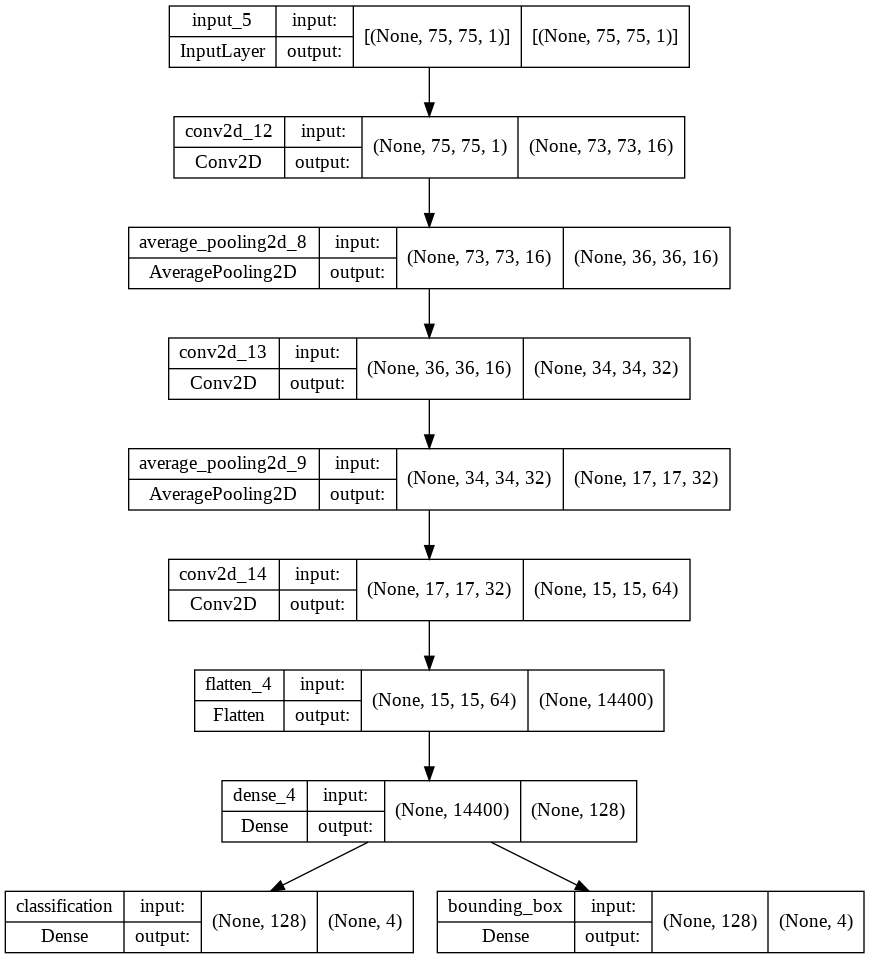

In [74]:
from tensorflow.keras.utils import plot_model

img_file = './model.png'

plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

In [86]:
##Train and Validate the Model

EPOCHS = 10
steps_per_epoch = 60000 // BATCH_SIZE
validation_steps = 1
history = model.fit(training_dataset, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classificatio_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=validation_steps)


Epoch 1/10
117/117 [==============================] - 12s 49ms/step - loss: 2.8987 - classification_loss: 2.3087 - bounding_box_loss: 0.5899 - classification_accuracy: 0.1973 - bounding_box_mse: 0.5899 - val_loss: 1.7620 - val_classification_loss: 1.7058 - val_bounding_box_loss: 0.0563 - val_classification_accuracy: 0.4354 - val_bounding_box_mse: 0.0563
Epoch 2/10
117/117 [==============================] - 4s 31ms/step - loss: 0.9870 - classification_loss: 0.9016 - bounding_box_loss: 0.0854 - classification_accuracy: 0.7139 - bounding_box_mse: 0.0854 - val_loss: 0.5356 - val_classification_loss: 0.4557 - val_bounding_box_loss: 0.0799 - val_classification_accuracy: 0.8720 - val_bounding_box_mse: 0.0799
Epoch 3/10
117/117 [==============================] - 4s 35ms/step - loss: 0.4547 - classification_loss: 0.3877 - bounding_box_loss: 0.0669 - classification_accuracy: 0.8885 - bounding_box_mse: 0.0669 - val_loss: 0.3540 - val_classification_loss: 0.2978 - val_bounding_box_loss: 0.0562 - v

NameError: ignored

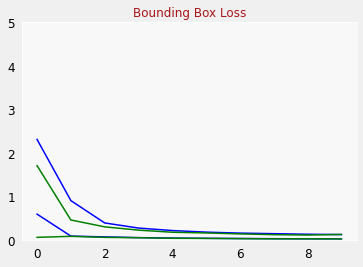

In [88]:
plot_metrics('classification_loss', 'Classification Loss')
plot_metrics('bounding_box_loss', 'Bounding Box Loss')

##Inersection over union

In [89]:
def intersection_over_union(pred_box, true_box):
  x_min_pred, y_min_pred, x_max_pred, y_max_pred = np.split(pred_box, 4, axis=1)
  x_min_true, y_min_true, x_max_true, y_max_true = np.split(true_box, 4, axis=1)

  smoothing_factor = 1e-10

  x_min_overlap = np.maximum(x_min_pred, x_min_true)
  x_max_overlap = np.minimum(x_max_pred, x_max_true)
  y_min_overlap = np.maximum(y_min_pred, y_min_true)
  y_max_overlap = np.minimum(y_max_pred, y_max_true)

  true_box_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
  pred_box_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)

  overlap_area = np.maximum((x_max_overlap - x_min_overlap), 0) * np.maximum((y_max_overlap - y_min_overlap), 0)

  union_area = true_box_area + pred_box_area - overlap_area

  iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

  return iou

##Visualize Predictions
The following code will make predictions and visualize both the classification and the predictied bounding boxes
* The true bounding box labels will be green and the model's predicted bounding boxes are red
* The predicted number is shown below the image 

Number of predictions where iou > threshold(0.6): 547
Number of predictions where iou < threshold(0.6): 9453


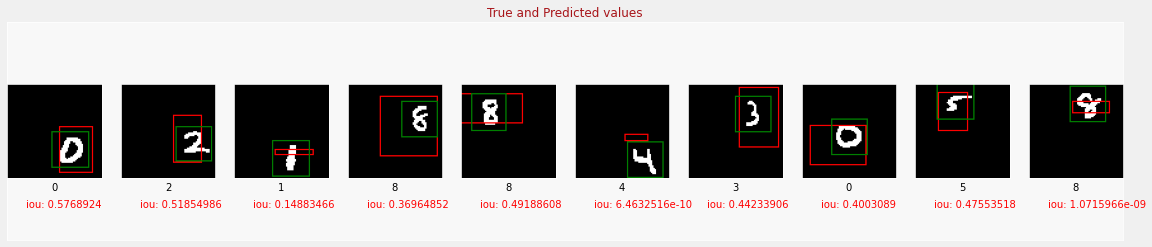

In [90]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")
